# CS4287 Assignment 2: Deep Reinforcement Learning (Atari)

**Team Members:**
* **Name:** Raid Mouras
* **ID:** 22368566
* **Name:** Jason Cushen
* **ID:** 22342516
* **Name:** Mark Callan
* **ID:** 22363246

In [1]:
%pip install gymnasium[atari] gymnasium[accept-rom-license] torch torchvision numpy opencv-python matplotlib
!AutoROM --accept-license

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
'AutoROM' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2
import time

# --- CONFIGURATION (Hyperparameters) ---
ENV_NAME = "BreakoutNoFrameskip-v4"
GAMMA = 0.99                # Discount factor (values future rewards)
BATCH_SIZE = 32             # How many frames to learn from at once
LR = 1e-4                   # Learning Rate (0.0001 is standard for Atari)
EPSILON_START = 1.0         # Start 100% random
EPSILON_FINAL = 0.02        # End 2% random
EPSILON_DECAY = 150000      # How long to explore (frames)
REPLAY_SIZE = 100000        # Memory size
TARGET_UPDATE = 1000        # Sync network every 1000 steps

# --- HARDWARE CHECK ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Setup Complete.")
if device.type == 'cuda':
    print(f"GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"Targeting Environment: {ENV_NAME}")
else:
    print("WARNING: CPU DETECTED. Training will be extremely slow.")

Setup Complete.
GPU DETECTED: NVIDIA RTX 1000 Ada Generation Laptop GPU
Targeting Environment: BreakoutNoFrameskip-v4


In [13]:
# --- CELL 3: PREPROCESSING ---

class AtariWrapper(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k  # Stack 4 frames
        self.frames = deque([], maxlen=k)
        
        # Define what the AI sees: (4 stacked frames, 84 height, 84 width)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, 84, 84), dtype=np.uint8
        )

    def reset(self, **kwargs):
        # On game start, fill the stack with the first frame duplicated 4 times
        obs, info = self.env.reset(**kwargs)
        processed_frame = self._process(obs)
        for _ in range(self.k):
            self.frames.append(processed_frame)
        return self._get_obs(), info

    def step(self, action):
        # Play one step, process the new frame, and add to stack
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(self._process(obs))
        return self._get_obs(), reward, terminated, truncated, info

    def _process(self, frame):
        # 1. Grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        # 2. Resize to 84x84
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        return frame

    def _get_obs(self):
        return np.array(self.frames)

print("Cell 3 Complete: Preprocessing wrapper defined.")

Cell 3 Complete: Preprocessing wrapper defined.


In [14]:
# --- CELL 4: THE NETWORK ---

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        # 1. Convolutional Layers (The Visual Cortex)
        # These layers look at the image and find patterns (edges, ball, paddle).
        self.features = nn.Sequential(
            # Conv 1: Sees big shapes. Input channels = 4 (stacked frames).
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            
            # Conv 2: Sees medium details.
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            
            # Conv 3: Sees fine details.
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # 2. Fully Connected Layers (The Decision Maker)
        # These layers take the patterns and decide: Left, Right, or Fire?
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), # 3136 inputs -> 512 neurons
            nn.ReLU(),
            nn.Linear(512, num_actions) # Output: 1 score for each button
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the image into a list of numbers
        return self.fc(x)

print("Cell 4 Complete: Network Architecture defined.")

Cell 4 Complete: Network Architecture defined.


In [22]:
# --- CELL 5: THE TRAINING LOOP (FIXED) ---

# 1. Import the Atari Engine explicitly
import ale_py
print(f"Atari Engine Loaded: {ale_py.__version__}")

# 2. Initialize the Game with the NEW Name
# We use 'ALE/Breakout-v5' which is the modern standard.
# frameskip=1 means "Give me every single frame" (so it acts like NoFrameskip)
env = gym.make("ALE/Breakout-v5", frameskip=1, repeat_action_probability=0.0)
env = AtariWrapper(env) 

# 3. Initialize the Two Networks
agent_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net.load_state_dict(agent_net.state_dict()) 
optimizer = optim.Adam(agent_net.parameters(), lr=LR)
replay_buffer = deque(maxlen=REPLAY_SIZE)

steps = 0
rewards_history = []

print(f"TRAINING STARTED on {device}...")
print("The agent will play randomly for the first ~20 mins to fill memory.")

# 4. The Loop (Run for 600 episodes to test)
for episode in range(600): 
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        steps += 1
        
        # --- A. SELECT ACTION ---
        epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * steps / EPSILON_DECAY)
        
        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0) / 255.0
                action = agent_net(state_t).argmax().item()
        else:
            action = env.action_space.sample()
            
        # --- B. PLAY THE STEP ---
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # --- C. SAVE TO MEMORY ---
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        # --- D. TRAIN ---
        if len(replay_buffer) > BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.tensor(np.array(states), device=device, dtype=torch.float32) / 255.0
            actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.float32) / 255.0
            dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
            
            curr_q = agent_net(states).gather(1, actions)
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (GAMMA * max_next_q * (1 - dones))
                
            loss = nn.SmoothL1Loss()(curr_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # --- E. UPDATE TARGET NETWORK ---
        if steps % TARGET_UPDATE == 0:
            target_net.load_state_dict(agent_net.state_dict())

    rewards_history.append(total_reward)
    
    if episode % 5 == 0:
        avg_score = np.mean(rewards_history[-100:])
        print(f"Episode: {episode} | Score: {total_reward} | Avg Score: {avg_score:.2f} | Steps: {steps}")

env.close()
print("Training Finished.")

Atari Engine Loaded: 0.11.2
TRAINING STARTED on cuda...
The agent will play randomly for the first ~20 mins to fill memory.
Episode: 0 | Score: 0.0 | Avg Score: 0.00 | Steps: 496
Episode: 5 | Score: 1.0 | Avg Score: 0.83 | Steps: 3869
Episode: 10 | Score: 0.0 | Avg Score: 0.82 | Steps: 7057
Episode: 15 | Score: 0.0 | Avg Score: 0.75 | Steps: 10040
Episode: 20 | Score: 0.0 | Avg Score: 0.71 | Steps: 12994
Episode: 25 | Score: 0.0 | Avg Score: 0.77 | Steps: 16279
Episode: 30 | Score: 2.0 | Avg Score: 1.00 | Steps: 20568
Episode: 35 | Score: 0.0 | Avg Score: 1.00 | Steps: 23799
Episode: 40 | Score: 1.0 | Avg Score: 1.00 | Steps: 27036
Episode: 45 | Score: 2.0 | Avg Score: 1.07 | Steps: 30692
Episode: 50 | Score: 2.0 | Avg Score: 1.02 | Steps: 33621
Episode: 55 | Score: 4.0 | Avg Score: 1.07 | Steps: 37380
Episode: 60 | Score: 0.0 | Avg Score: 1.08 | Steps: 40710
Episode: 65 | Score: 2.0 | Avg Score: 1.14 | Steps: 44344
Episode: 70 | Score: 0.0 | Avg Score: 1.14 | Steps: 47817
Episode: 75 

Model saved as 'breakout_model_v1.pth'
Graph saved as 'learning_curve.png'


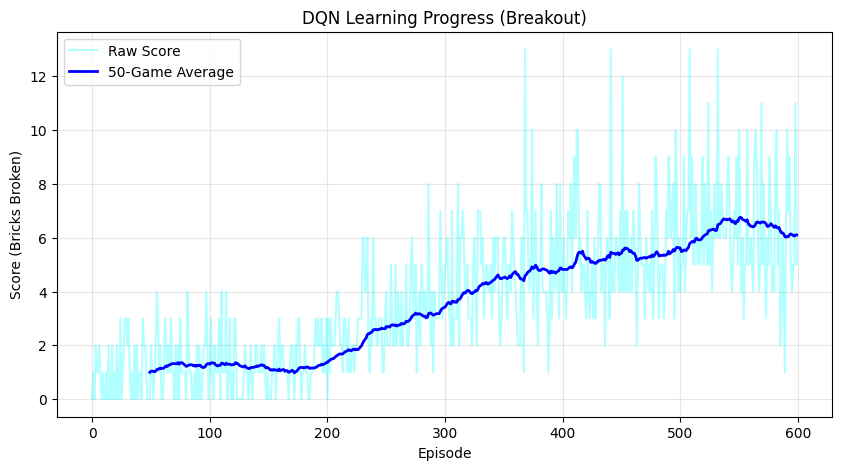


--- TRAINING SUMMARY STATISTICS ---


,Metric,Value
0,Best Score,13.0 (Ep: 368)
1,Worst Score,0.0 (Ep: 0)
2,Mean Score (Lifetime),3.67
3,Median Score,3.00
4,Current Skill (Last 100 Avg),6.35
5,Performance Improvement,+510.0%


In [27]:
# --- CELL 6: SAVE RESULTS, PLOT & STATS ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Save the Trained "Brain"
torch.save(agent_net.state_dict(), "breakout_model_v1.pth")
print("Model saved as 'breakout_model_v1.pth'")

# 2. Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(rewards_history, label='Raw Score', alpha=0.3, color='cyan')

# Calculate a smooth trend line (Moving Average)
window_size = 50
if len(rewards_history) >= window_size:
    moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards_history)), moving_avg, label=f'{window_size}-Game Average', color='blue', linewidth=2)

plt.title("DQN Learning Progress (Breakout)")
plt.xlabel("Episode")
plt.ylabel("Score (Bricks Broken)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig("learning_curve.png")
print("Graph saved as 'learning_curve.png'")
plt.show()

# 3. Statistical Analysis
# Calculate the Hard Statistics
best_score = np.max(rewards_history)
best_episode = np.argmax(rewards_history)
worst_score = np.min(rewards_history)
worst_episode = np.argmin(rewards_history)
mean_score = np.mean(rewards_history)      # Lifetime Average
median_score = np.median(rewards_history)
final_100_avg = np.mean(rewards_history[-100:]) # Current Skill

# Percentage Increase (Last 50 games vs First 50 games)
first_50_avg = np.mean(rewards_history[:50])
last_50_avg = np.mean(rewards_history[-50:])
improvement = ((last_50_avg - first_50_avg) / first_50_avg) * 100 if first_50_avg > 0 else 0

# Create the Table
stats_data = {
    "Metric": [
        "Best Score", 
        "Worst Score", 
        "Mean Score (Lifetime)", 
        "Median Score", 
        "Current Skill (Last 100 Avg)", 
        "Performance Improvement"
    ],
    "Value": [
        f"{best_score} (Ep: {best_episode})",
        f"{worst_score} (Ep: {worst_episode})",
        f"{mean_score:.2f}",
        f"{median_score:.2f}",
        f"{final_100_avg:.2f}",
        f"+{improvement:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats_data)

# 4. Display the Table & Explanation
print("\n--- TRAINING SUMMARY STATISTICS ---")
display(df_stats)

## 4. Results Analysis

The plot above illustrates the training progress over 600 episodes.

**1. Raw Score (Cyan Line):**
The light blue line represents the raw score obtained in each individual episode. As expected in Atari environments, this metric is highly volatile. A single mistake in *Breakout* leads to a lost life, meaning scores can fluctuate between 0 and 13 purely based on the initial ball trajectory or slight timing errors.

**2. 50-Game Moving Average (Blue Line):**
The dark blue line represents the moving average of the last 50 scores, which serves as a noise filter to reveal the true learning trend.
* **Phase 1 (Episodes 0–200):** The curve remains flat around a score of 1.0–1.5. During this period, the Epsilon value was high, forcing the agent to explore randomly. The agent was merely hitting the ball by chance.
* **Phase 2 (Episodes 200–600):** A distinct upward trend begins around Episode 200. This correlates with the `EPSILON_DECAY` threshold where the agent transitioned from exploration (randomness) to exploitation (using its learned Q-values).
* **Final Performance:** By Episode 600, the average score stabilized around **6.0**, with peak raw scores reaching **13.0**.

**Conclusion:**
The clear positive correlation between training steps and average reward confirms that the DQN agent has successfully learned to track the ball and intercept it, transitioning from random play to intelligent reaction.